## MINERvA ME flux reweight: GENIE $\to$ NEUT


In [1]:
import sys
# Change this path to your working directory where BDTReweight is installed:
sys.path.append('/exp/minerva/app/users/zihaolin/REWEIGHTworkdir/')

from BDTReweight.analysis import transform_momentum_to_reaction_frame, create_dataframe_from_nuisance, draw_source_target_distributions_and_ratio
from BDTReweight.nuisance_flat_tree import NuisanceFlatTree
from BDTReweight.reweighter import Reweighter
from BDTReweight.utilities import particle_variable_to_latex, diff_xsec_latex_wrt_variable
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt


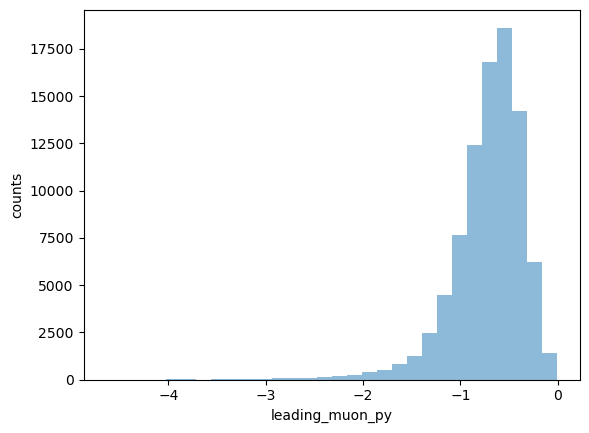

In [2]:
tree_source_train = uproot.open('/exp/minerva/data/users/zihaolin/MC_outputs/Lorenzo/source/minervame1L_test_rwg.root')['EventKinematics'].arrays(library='pd')

topologies = {0:'0p0n',1:'0pNn',2:'1p0n',3:'1pNn',4:'2p0n',5:'2pNn',6:'others'}
tree_source_train['topology'] = tree_source_train['topology'].map(topologies)
tree_source_train = tree_source_train.rename(columns={'muon_py':'leading_muon_py', 'muon_pz':'leading_muon_pz',
    'sum_p_px':'total_proton_px', 'sum_p_py':'total_proton_py', 'sum_p_pz':'total_proton_pz', 'sum_Tp':'total_proton_KE', 'leading_n_px':'leading_neutron_px',
    'leading_n_py':'leading_neutron_py', 'leading_n_pz':'leading_neutron_pz', 'leading_p_px':'leading_proton_px', 'leading_p_py':'leading_proton_py',
    'leading_p_pz':'leading_proton_pz', 'subleading_p_px':'subleading_proton_px', 'subleading_p_py':'subleading_proton_py', 'subleading_p_pz':'subleading_proton_pz'}
)

for column in ['leading_muon_py','total_proton_px','total_proton_py','leading_proton_px', 'leading_proton_py','subleading_proton_px', 
        'subleading_proton_py','leading_neutron_px', 'leading_neutron_pz']:
    tree_source_train[column] = - tree_source_train[column]

tree_source_train = tree_source_train.replace(999.0, -999.0)

plt.figure()
plt.hist(tree_source_train[tree_source_train['topology']=='1p0n']['leading_muon_py'], bins = 30, label='source model',alpha=0.5)
plt.xlabel('leading_muon_py')
plt.ylabel('counts')

plt.show()

source_train = {}
source_test = {}
for topology in topologies.values():
    source_train[topology] = tree_source_train[tree_source_train['topology']==topology].copy()
    # create a temporary test set 
    source_test[topology] = source_train[topology].iloc[np.arange(0, int(len(source_train[topology])/7.53),1)].copy()



In [3]:
tree_target_train = NuisanceFlatTree('/exp/minerva/data/users/zihaolin/MC_outputs/Lorenzo/neut_MINERvAflux_EDRMF_nu_nuisflat.root')
mask_CCQELike = (tree_target_train.get_mask_final_state_allowed_pdg([13, 2212, 2112]) & tree_target_train.get_mask_topology({'proton':'>=1'}))
tree_target_train.update_tree_with_mask(mask_CCQELike)
target_train = {}
target_test = {}
# Specify detecting thresholds and topology particle counts:
KE_thresholds={'proton':0.05, 'neutron':0.01}
# scale_source_train = len(tree_target_train._flattree_vars)/len(tree_source_train)
scale_source_train = 2.489225788674492e-44
scale_target_train = 1.84e-43


### CCQE-like 1 $\mu$ 0p0n:

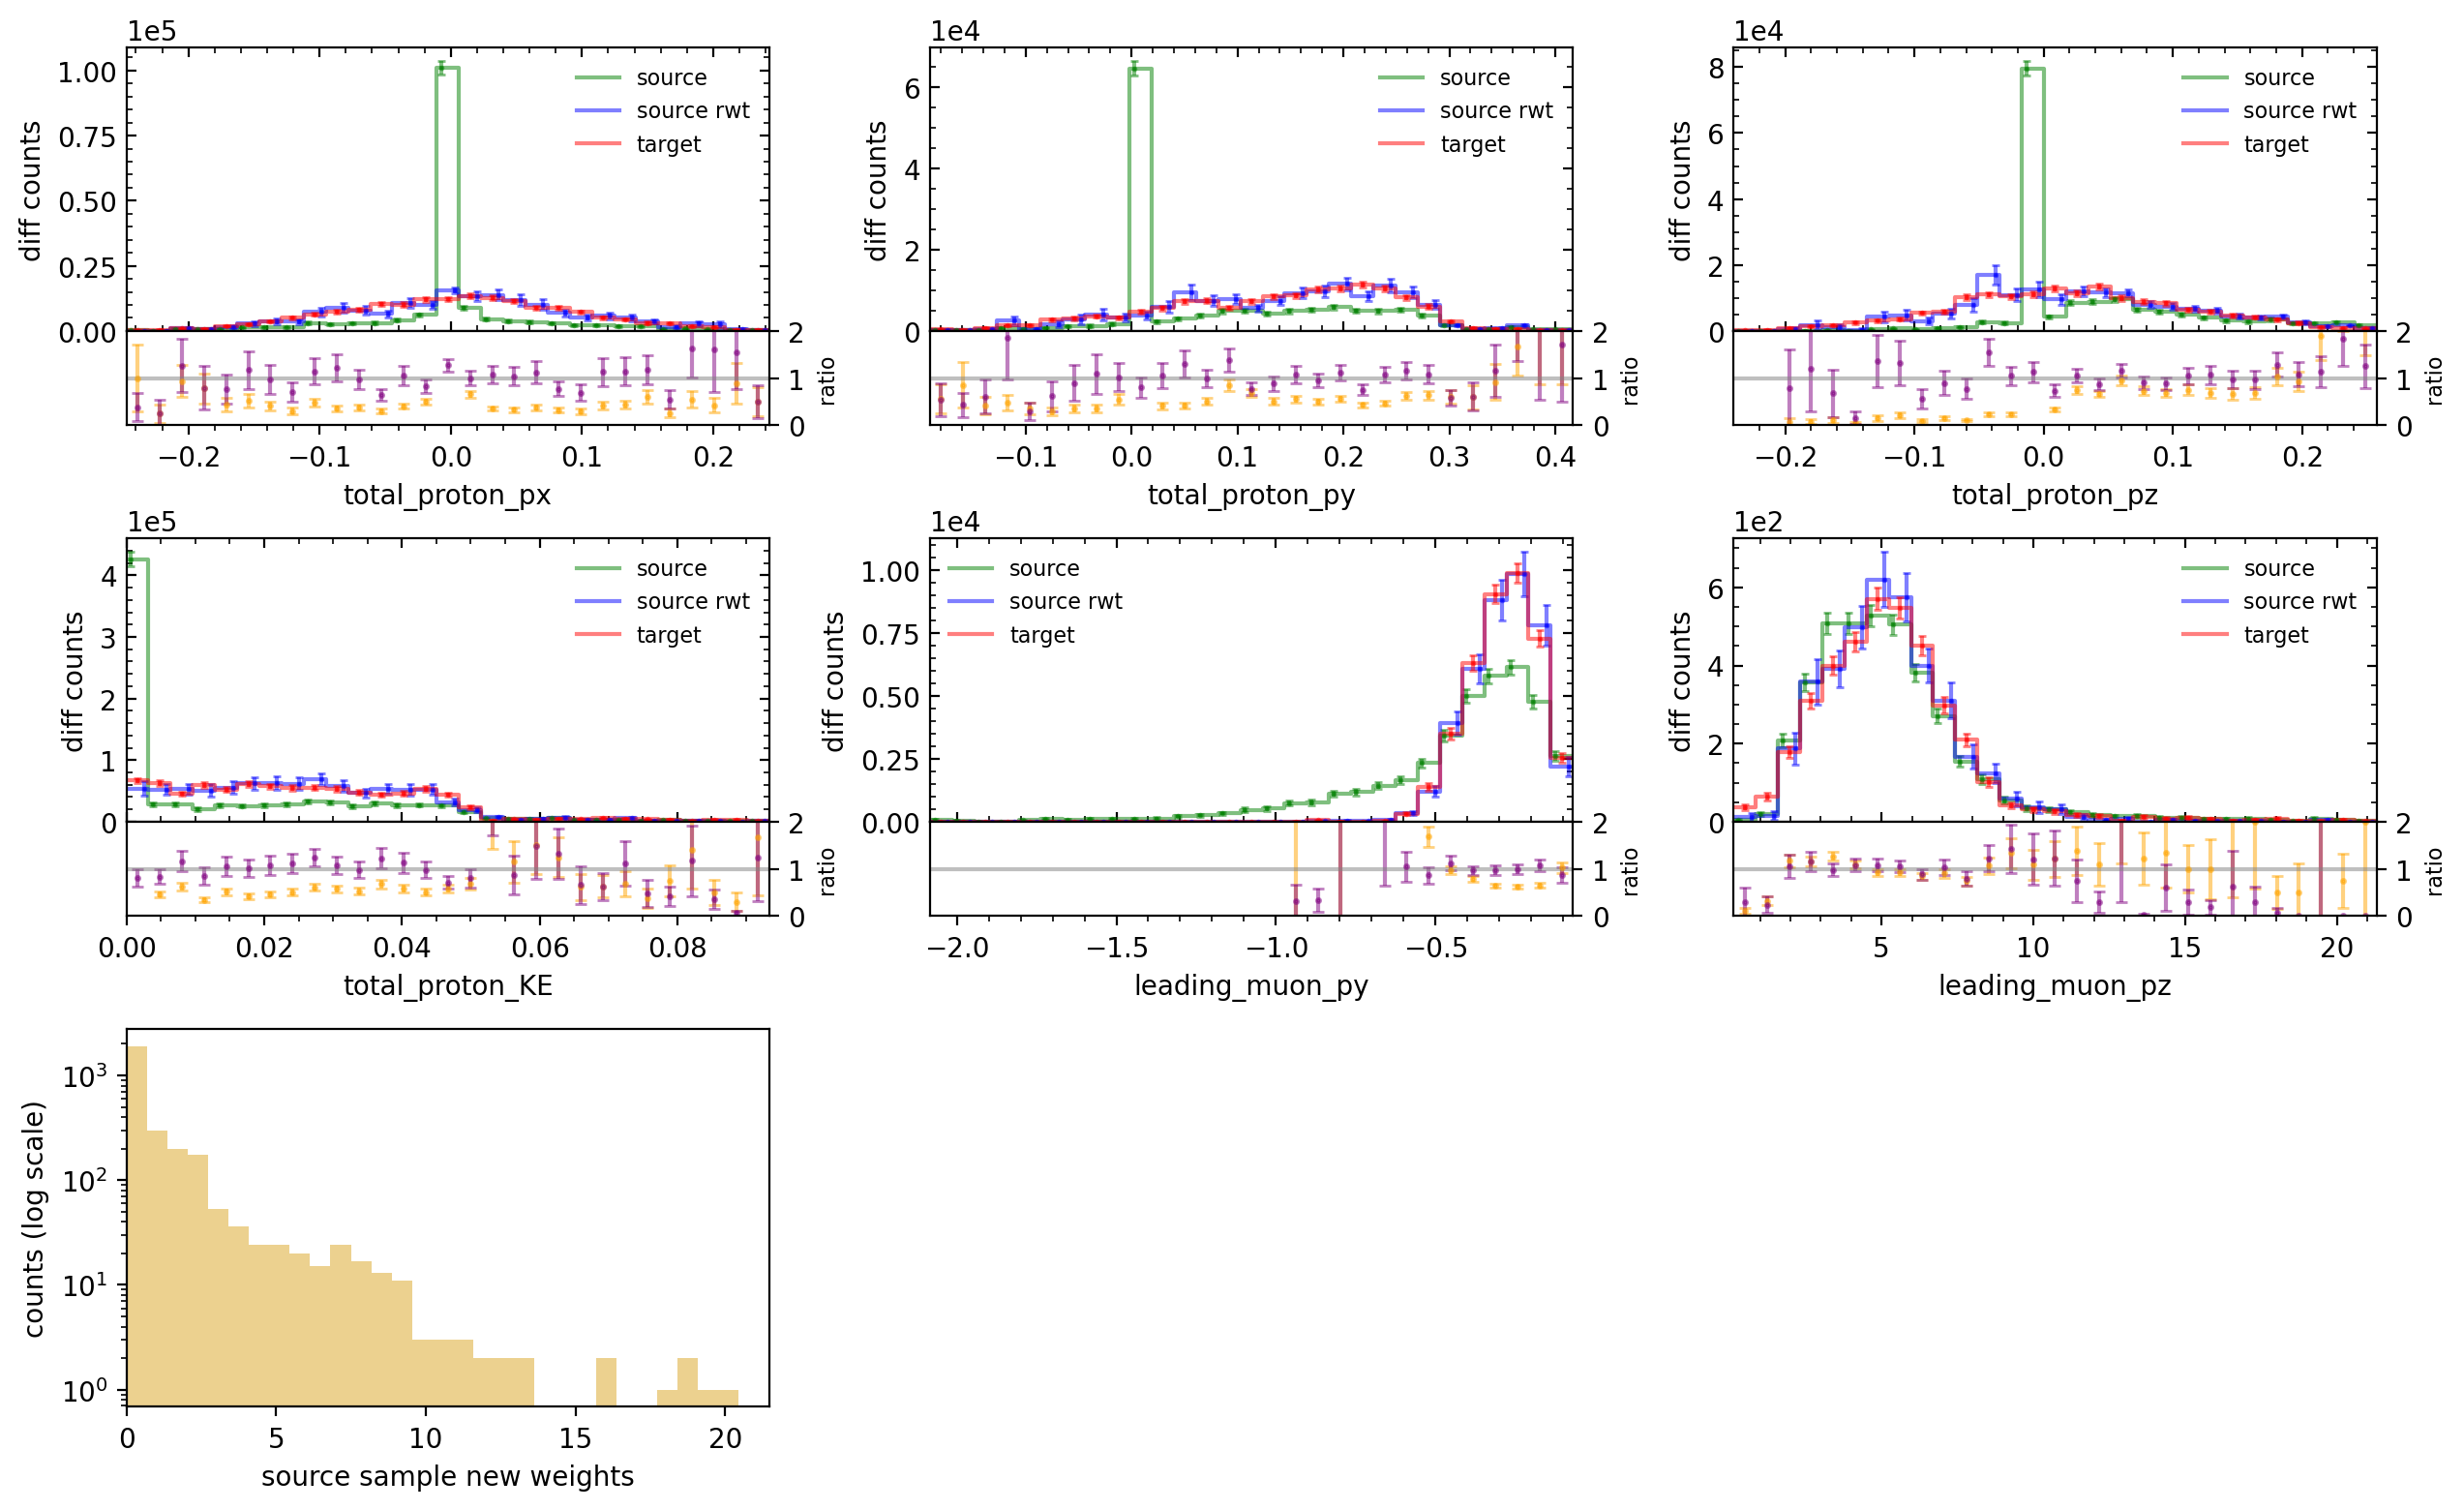

In [4]:
# Category name:
category = '0p0n'
particle_counts = {'muon':'==1', 'proton':'==0', 'neutron':'==0'}
variable_exprs = [
    'Enu_true', 'Q2', 'q0', 'q3', 'W',
    'leading_muon_px', 'leading_muon_py', 'leading_muon_pz', 'leading_muon_KE',
    'total_proton_px', 'total_proton_py', 'total_proton_pz', 'total_proton_KE',
]
reweight_variables=['total_proton_px','total_proton_py','total_proton_pz','total_proton_KE','leading_muon_py','leading_muon_pz']
drawing_variables = ['total_proton_px','total_proton_py','total_proton_pz','total_proton_KE','leading_muon_py','leading_muon_pz', 'weight']
particle_names = ['total_proton']

mask = tree_target_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_train[category] = create_dataframe_from_nuisance(tree_target_train, variable_exprs=variable_exprs, mask=mask)
target_train[category] = transform_momentum_to_reaction_frame(target_train[category], selector_lepton='leading_muon', particle_names=particle_names)

target_test[category] = target_train[category].copy()

reweighter = Reweighter(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=30, gb_args={'subsample': 1.0})
reweighter.fit(source_train[category][reweight_variables], target_train[category][reweight_variables])


target_test[category]['weight'] = 1.0
source_test[category]['weight'] = reweighter.predict_matched_total_weights(
    source_test[category][reweight_variables], 
    original_weight=None,
    target_weight=target_test[category]['weight']
)

draw_source_target_distributions_and_ratio(source_test[category], target_test[category], 
    variables = drawing_variables,
    source_weights = np.ones(len(source_test[category])),
    target_weights = np.ones(len(target_test[category])), 
    new_source_weights = source_test[category]['weight'],
    # xlabels = [particle_variable_to_latex(var) for var in drawing_variables],
    # ylabels = [diff_xsec_latex_wrt_variable(var) for var in drawing_variables],
    # scale_source = scale_source_test, scale_target = scale_target_test
)


### CCQE-like 1 $\mu$ 0pNn:

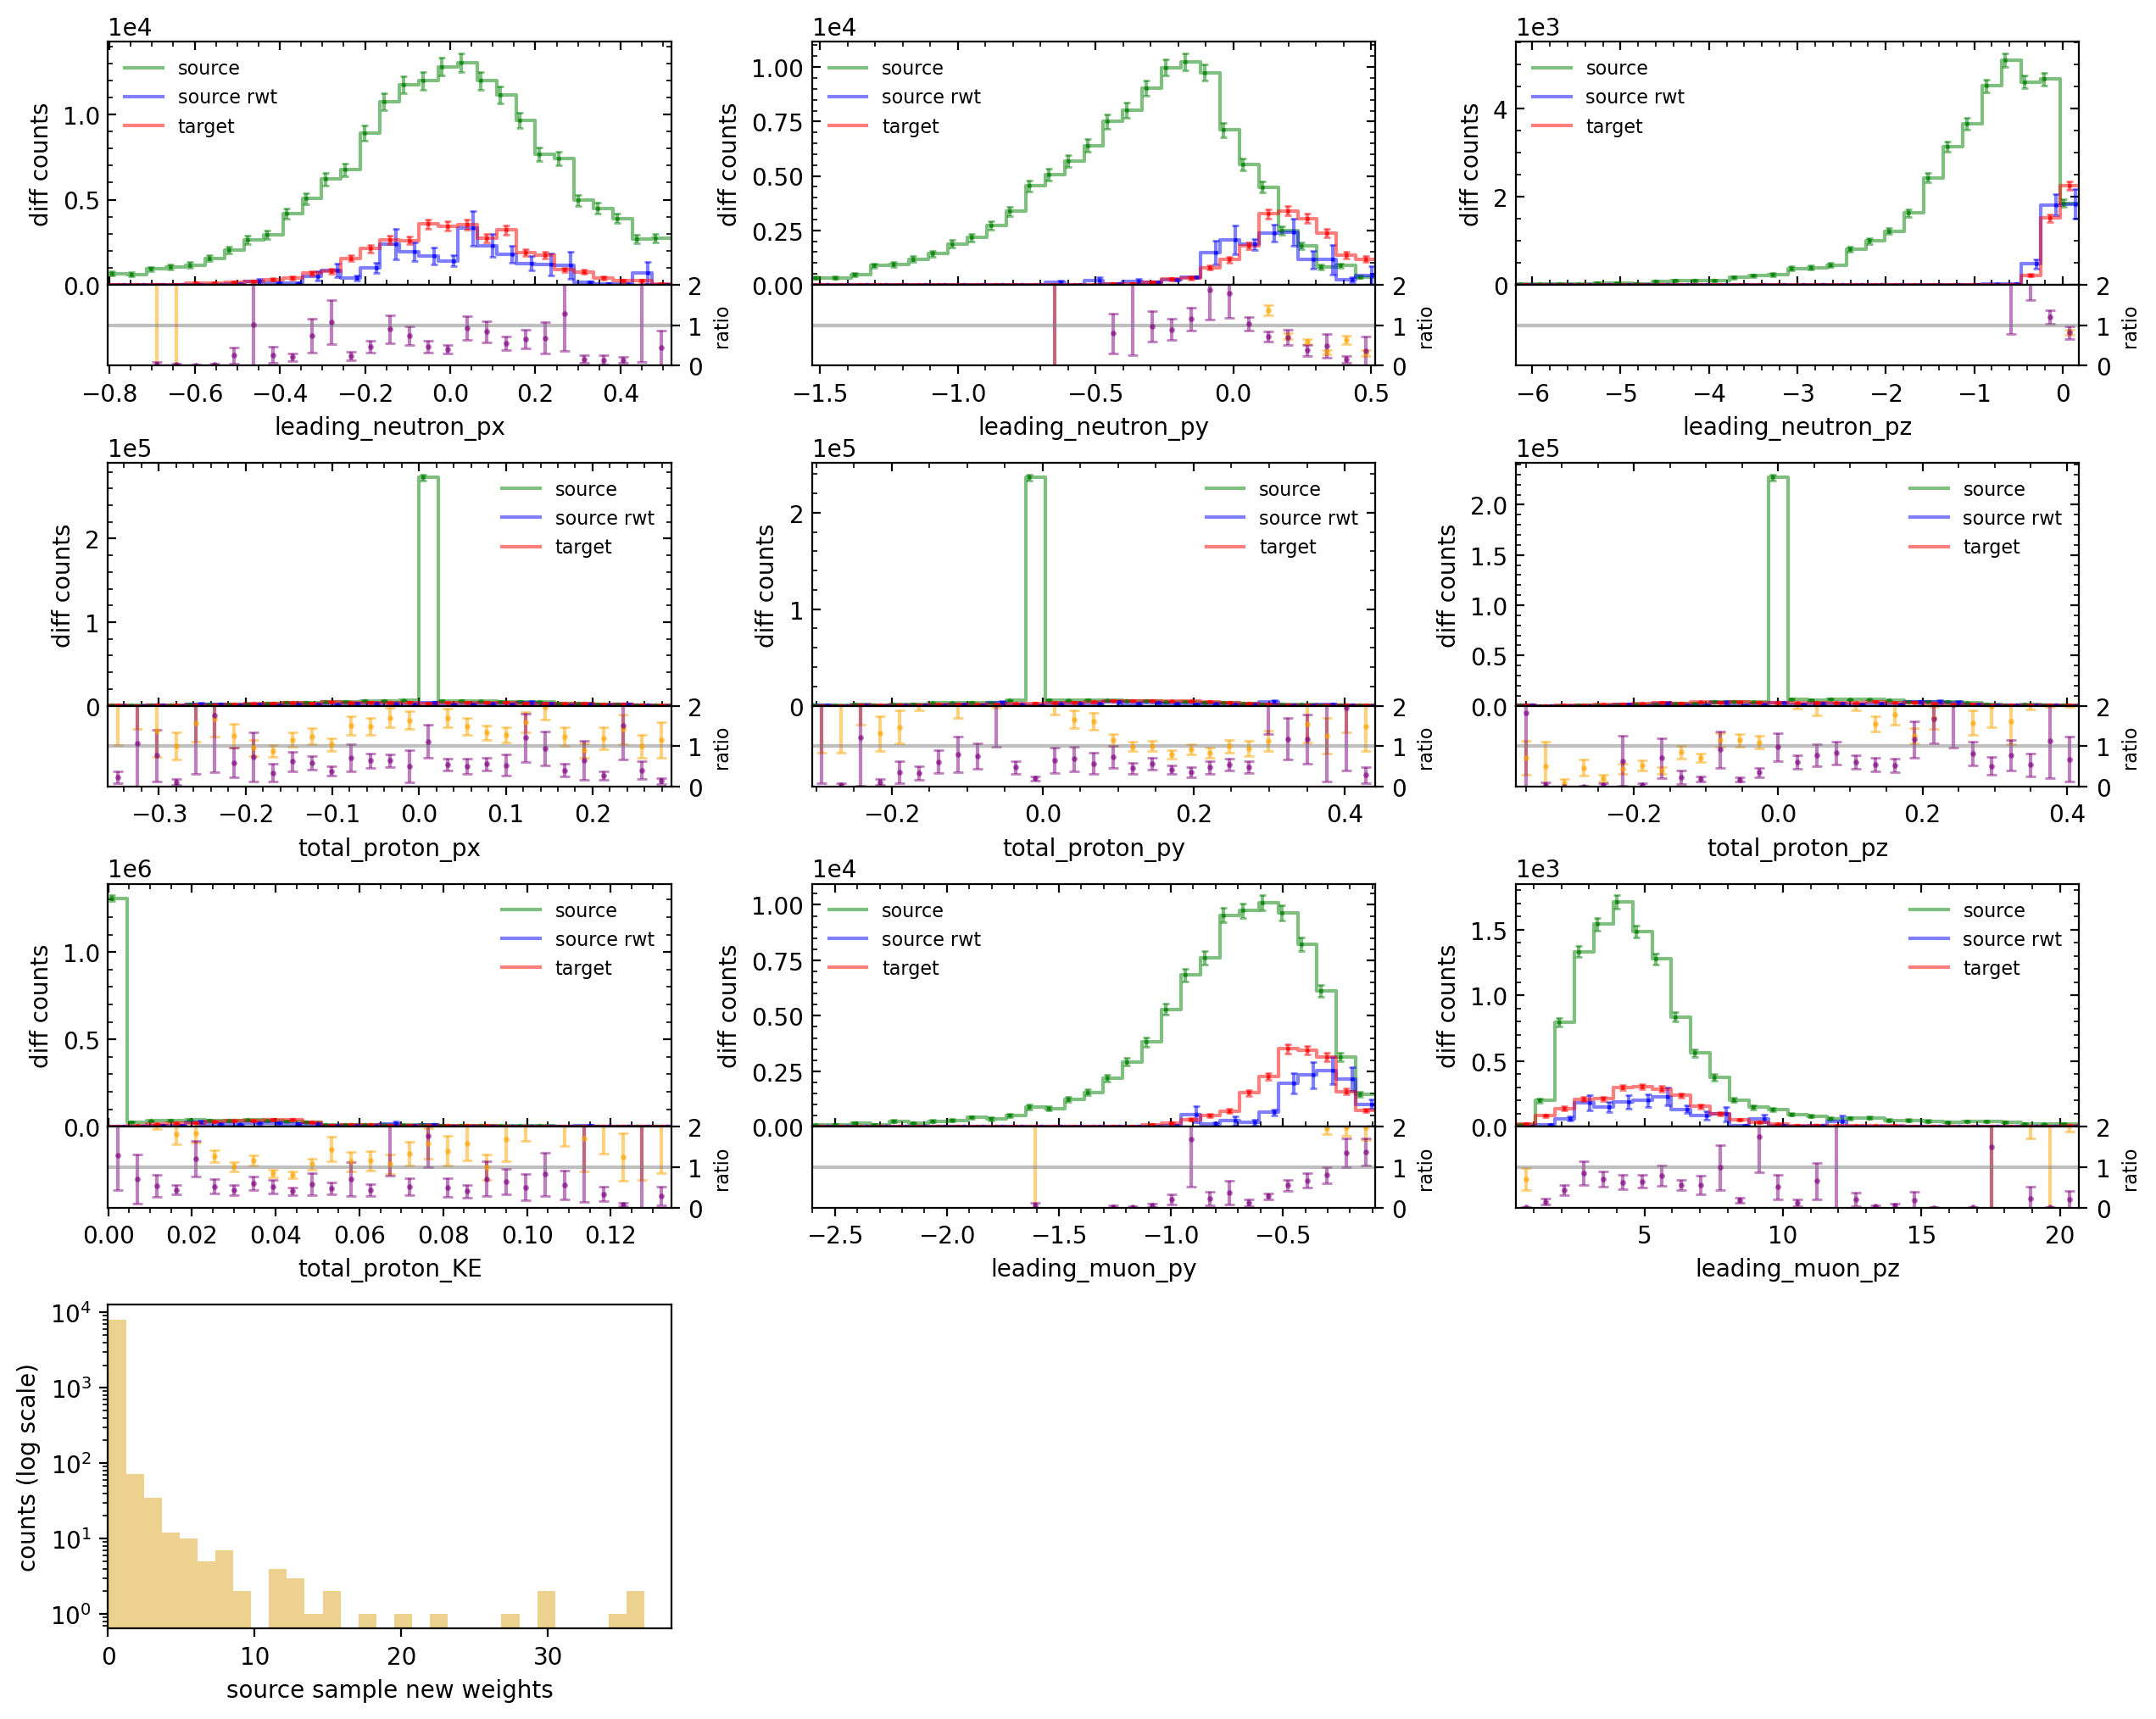

In [5]:
category = '0pNn'
particle_counts = {'muon':'==1', 'proton':'==0', 'neutron':'>=1'}
variable_exprs = [
    'Enu_true', 'Q2', 'q0', 'q3', 'W',
    'leading_muon_px', 'leading_muon_py', 'leading_muon_pz', 'leading_muon_KE',
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz', 'leading_neutron_KE',
    'total_proton_px', 'total_proton_py', 'total_proton_pz', 'total_proton_KE',
]
reweight_variables = [
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'total_proton_px','total_proton_py','total_proton_pz',
    'total_proton_KE','leading_muon_py','leading_muon_pz'
]
particle_names = ['leading_neutron','total_proton']
drawing_variables = [
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'total_proton_px','total_proton_py','total_proton_pz',
    'total_proton_KE','leading_muon_py','leading_muon_pz', 'weight'
]

mask = tree_target_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_train[category] = create_dataframe_from_nuisance(tree_target_train, variable_exprs=variable_exprs, mask=mask)
target_train[category] = transform_momentum_to_reaction_frame(target_train[category], selector_lepton='leading_muon', particle_names=particle_names)

target_test[category] = target_train[category].copy()

reweighter = Reweighter(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=30, gb_args={'subsample': 1.0})
reweighter.fit(source_train[category][reweight_variables], target_train[category][reweight_variables])


target_test[category]['weight'] = 1.0
source_test[category]['weight'] = reweighter.predict_matched_total_weights(
    source_test[category][reweight_variables], 
    original_weight=None,
    target_weight=target_test[category]['weight']
)
source_test[category] = source_test[category].loc[source_test[category]['weight']<40]

draw_source_target_distributions_and_ratio(source_test[category], target_test[category], 
    variables = drawing_variables,
    source_weights = np.ones(len(source_test[category])),
    target_weights = np.ones(len(target_test[category])), 
    new_source_weights = source_test[category]['weight'],
    # xlabels = [particle_variable_to_latex(var) for var in drawing_variables],
    # ylabels = [diff_xsec_latex_wrt_variable(var) for var in drawing_variables],
    # scale_source = scale_source_test, scale_target = scale_target_test
)


### CCQE-like 1 $\mu$ 1p0n:

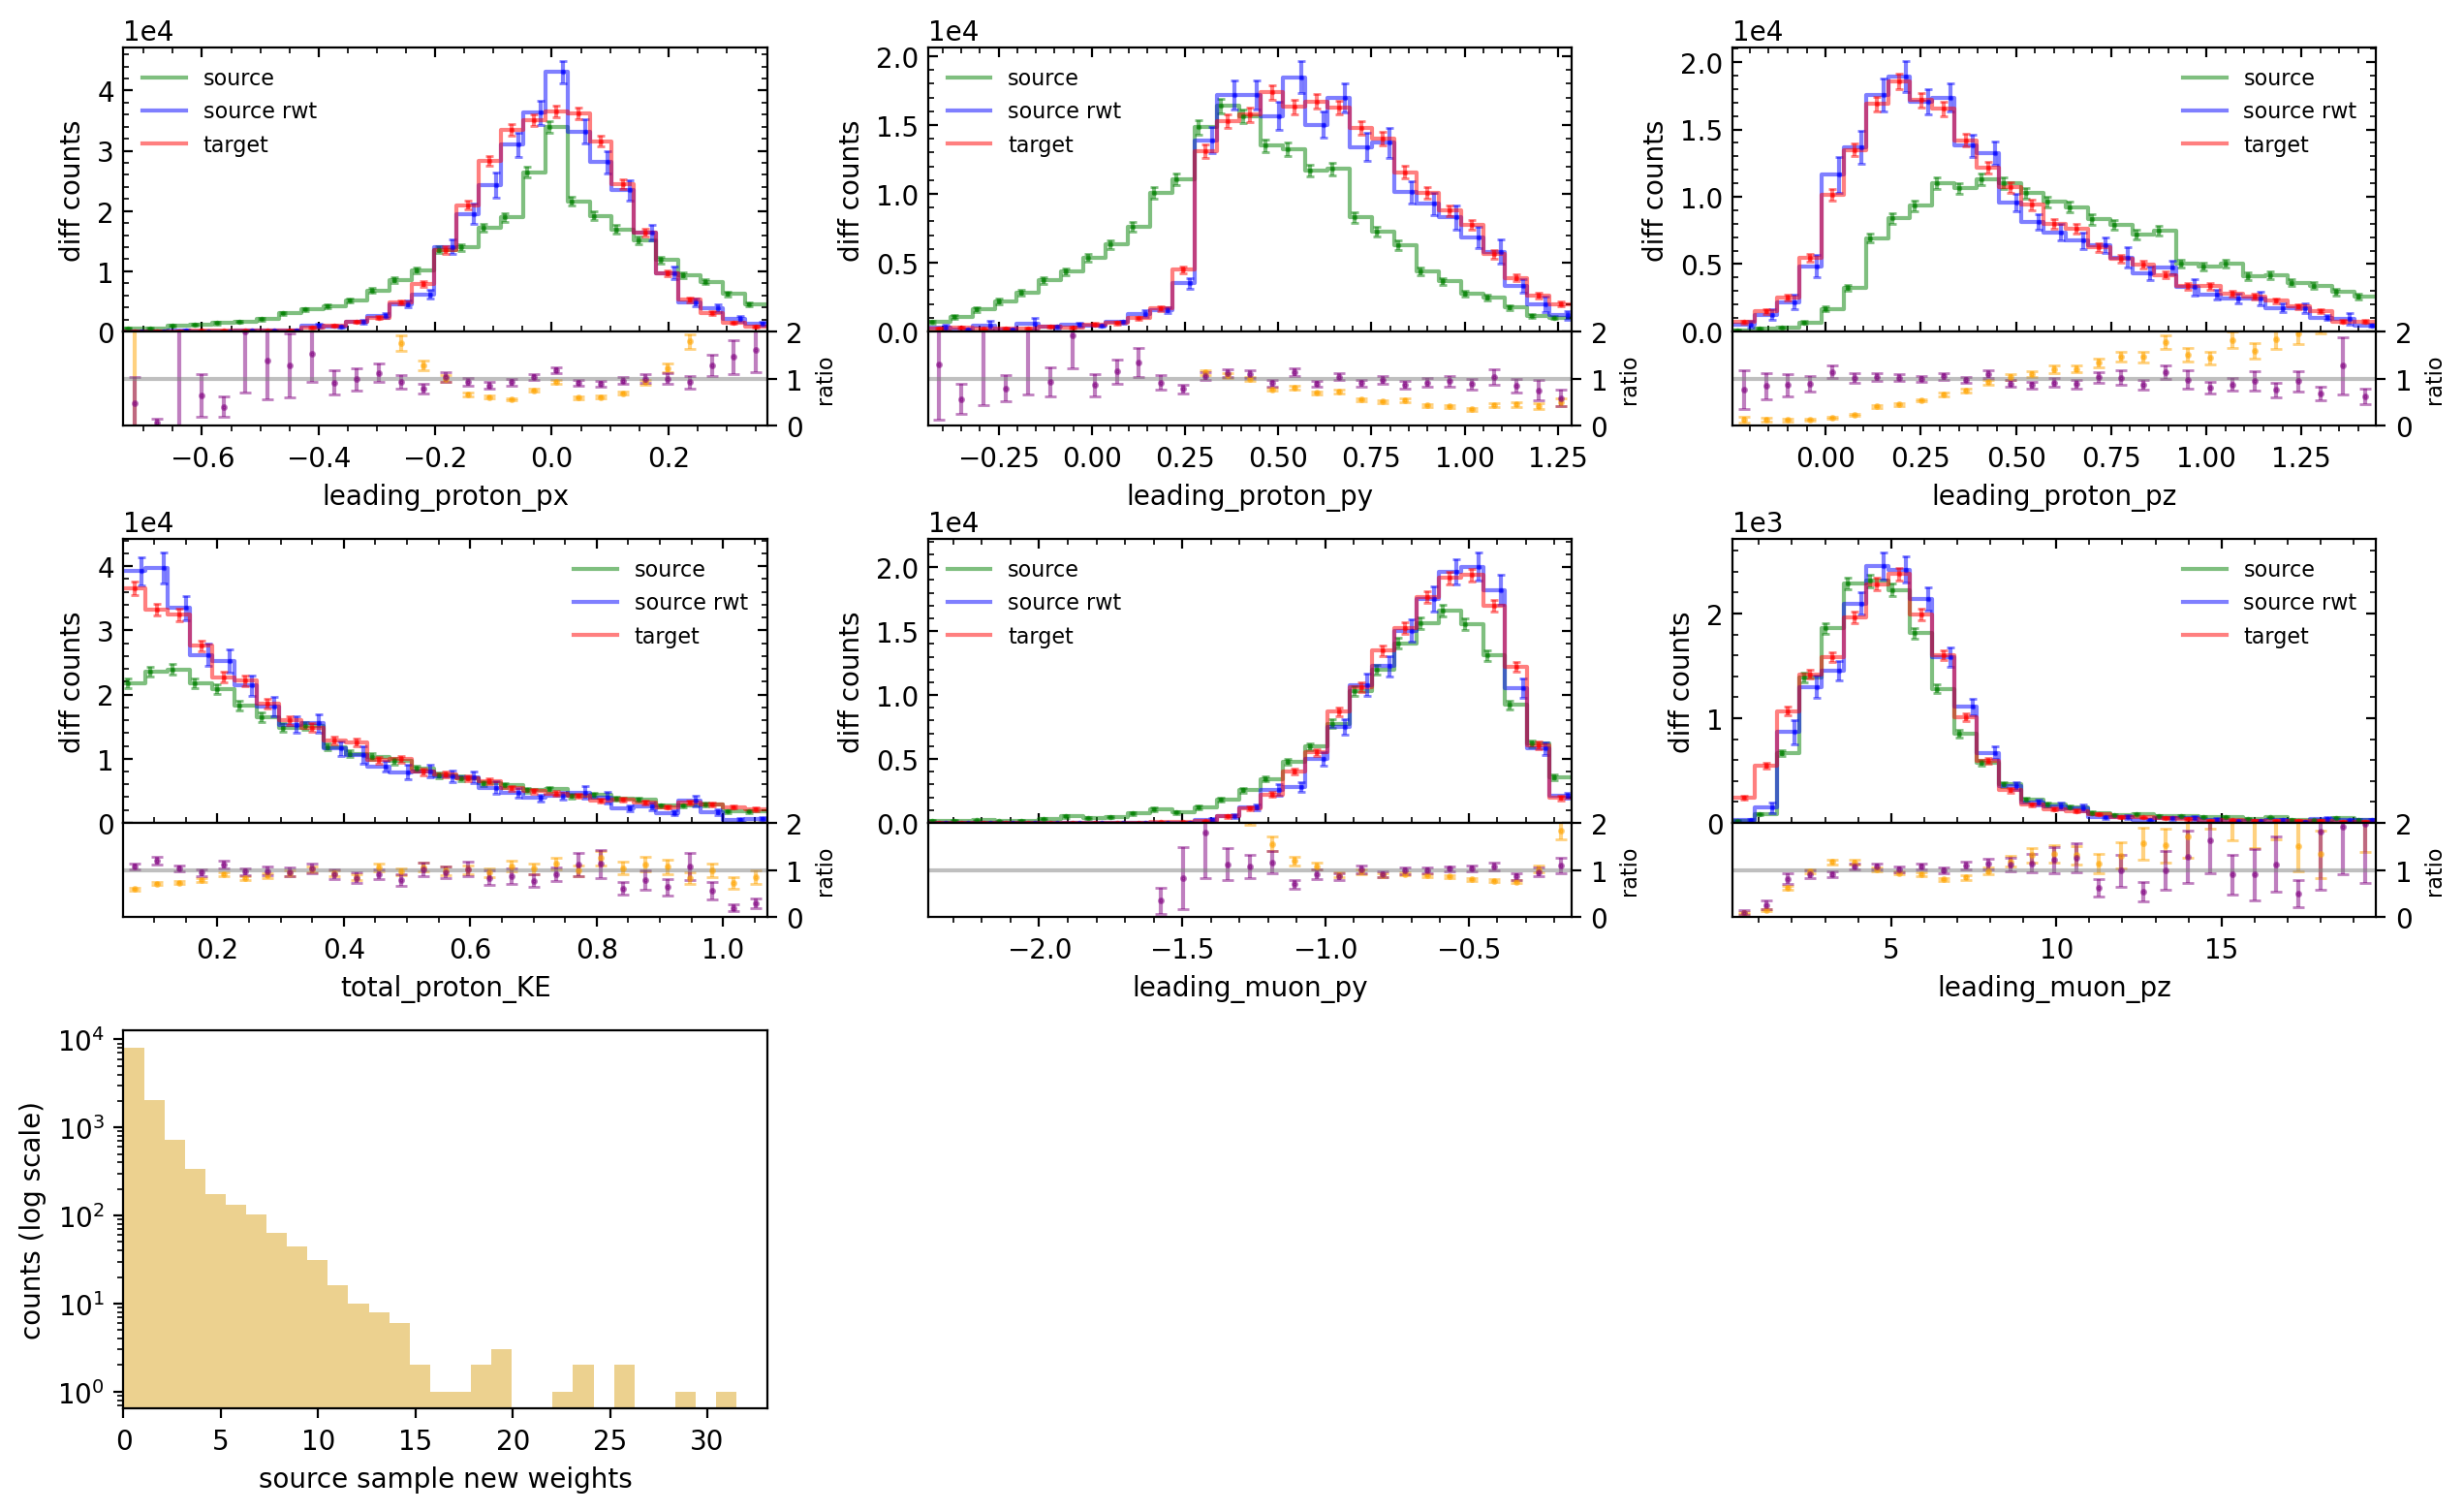

In [6]:
category = '1p0n'
particle_counts = {'muon':'==1', 'proton':'==1', 'neutron':'==0'}
variable_exprs = [
    'Enu_true', 'Q2', 'q0', 'q3', 'W',
    'dalphat', 'dpt', 'dphit',
    'leading_muon_px', 'leading_muon_py', 'leading_muon_pz', 'leading_muon_KE',
    'total_proton_px', 'total_proton_py', 'total_proton_pz', 'total_proton_KE',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz', 'leading_proton_KE',
]
reweight_variables=['leading_proton_px','leading_proton_py','leading_proton_pz','total_proton_KE','leading_muon_py','leading_muon_pz']
particle_names = ['leading_proton','total_proton']
drawing_variables = [
    'leading_proton_px','leading_proton_py','leading_proton_pz',
    'total_proton_KE','leading_muon_py','leading_muon_pz', 
    # 'total_proton_px','total_proton_py','total_proton_pz', 
    # 'dalphat', 'dpt', 'dphit', 
    'weight'
]

mask = tree_target_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_train[category] = create_dataframe_from_nuisance(tree_target_train, variable_exprs=variable_exprs, mask=mask)
target_train[category] = transform_momentum_to_reaction_frame(target_train[category], selector_lepton='leading_muon', particle_names=particle_names)

target_test[category] = target_train[category].copy()

reweighter = Reweighter(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=30, gb_args={'subsample': 1.0})
reweighter.fit(source_train[category][reweight_variables], target_train[category][reweight_variables])


target_test[category]['weight'] = 1.0
source_test[category]['weight'] = reweighter.predict_matched_total_weights(
    source_test[category][reweight_variables], 
    original_weight=None,
    target_weight=target_test[category]['weight']
)
source_test[category] = source_test[category].loc[source_test[category]['weight']<40]

draw_source_target_distributions_and_ratio(source_test[category], target_test[category], 
    variables = drawing_variables,
    source_weights = np.ones(len(source_test[category])),
    target_weights = np.ones(len(target_test[category])), 
    new_source_weights = source_test[category]['weight'],
    # xlabels = [particle_variable_to_latex(var) for var in drawing_variables],
    # ylabels = [diff_xsec_latex_wrt_variable(var) for var in drawing_variables],
    # scale_source = scale_source_test, scale_target = scale_target_test
)


### CCQE-like 1 $\mu$ 1pNn:

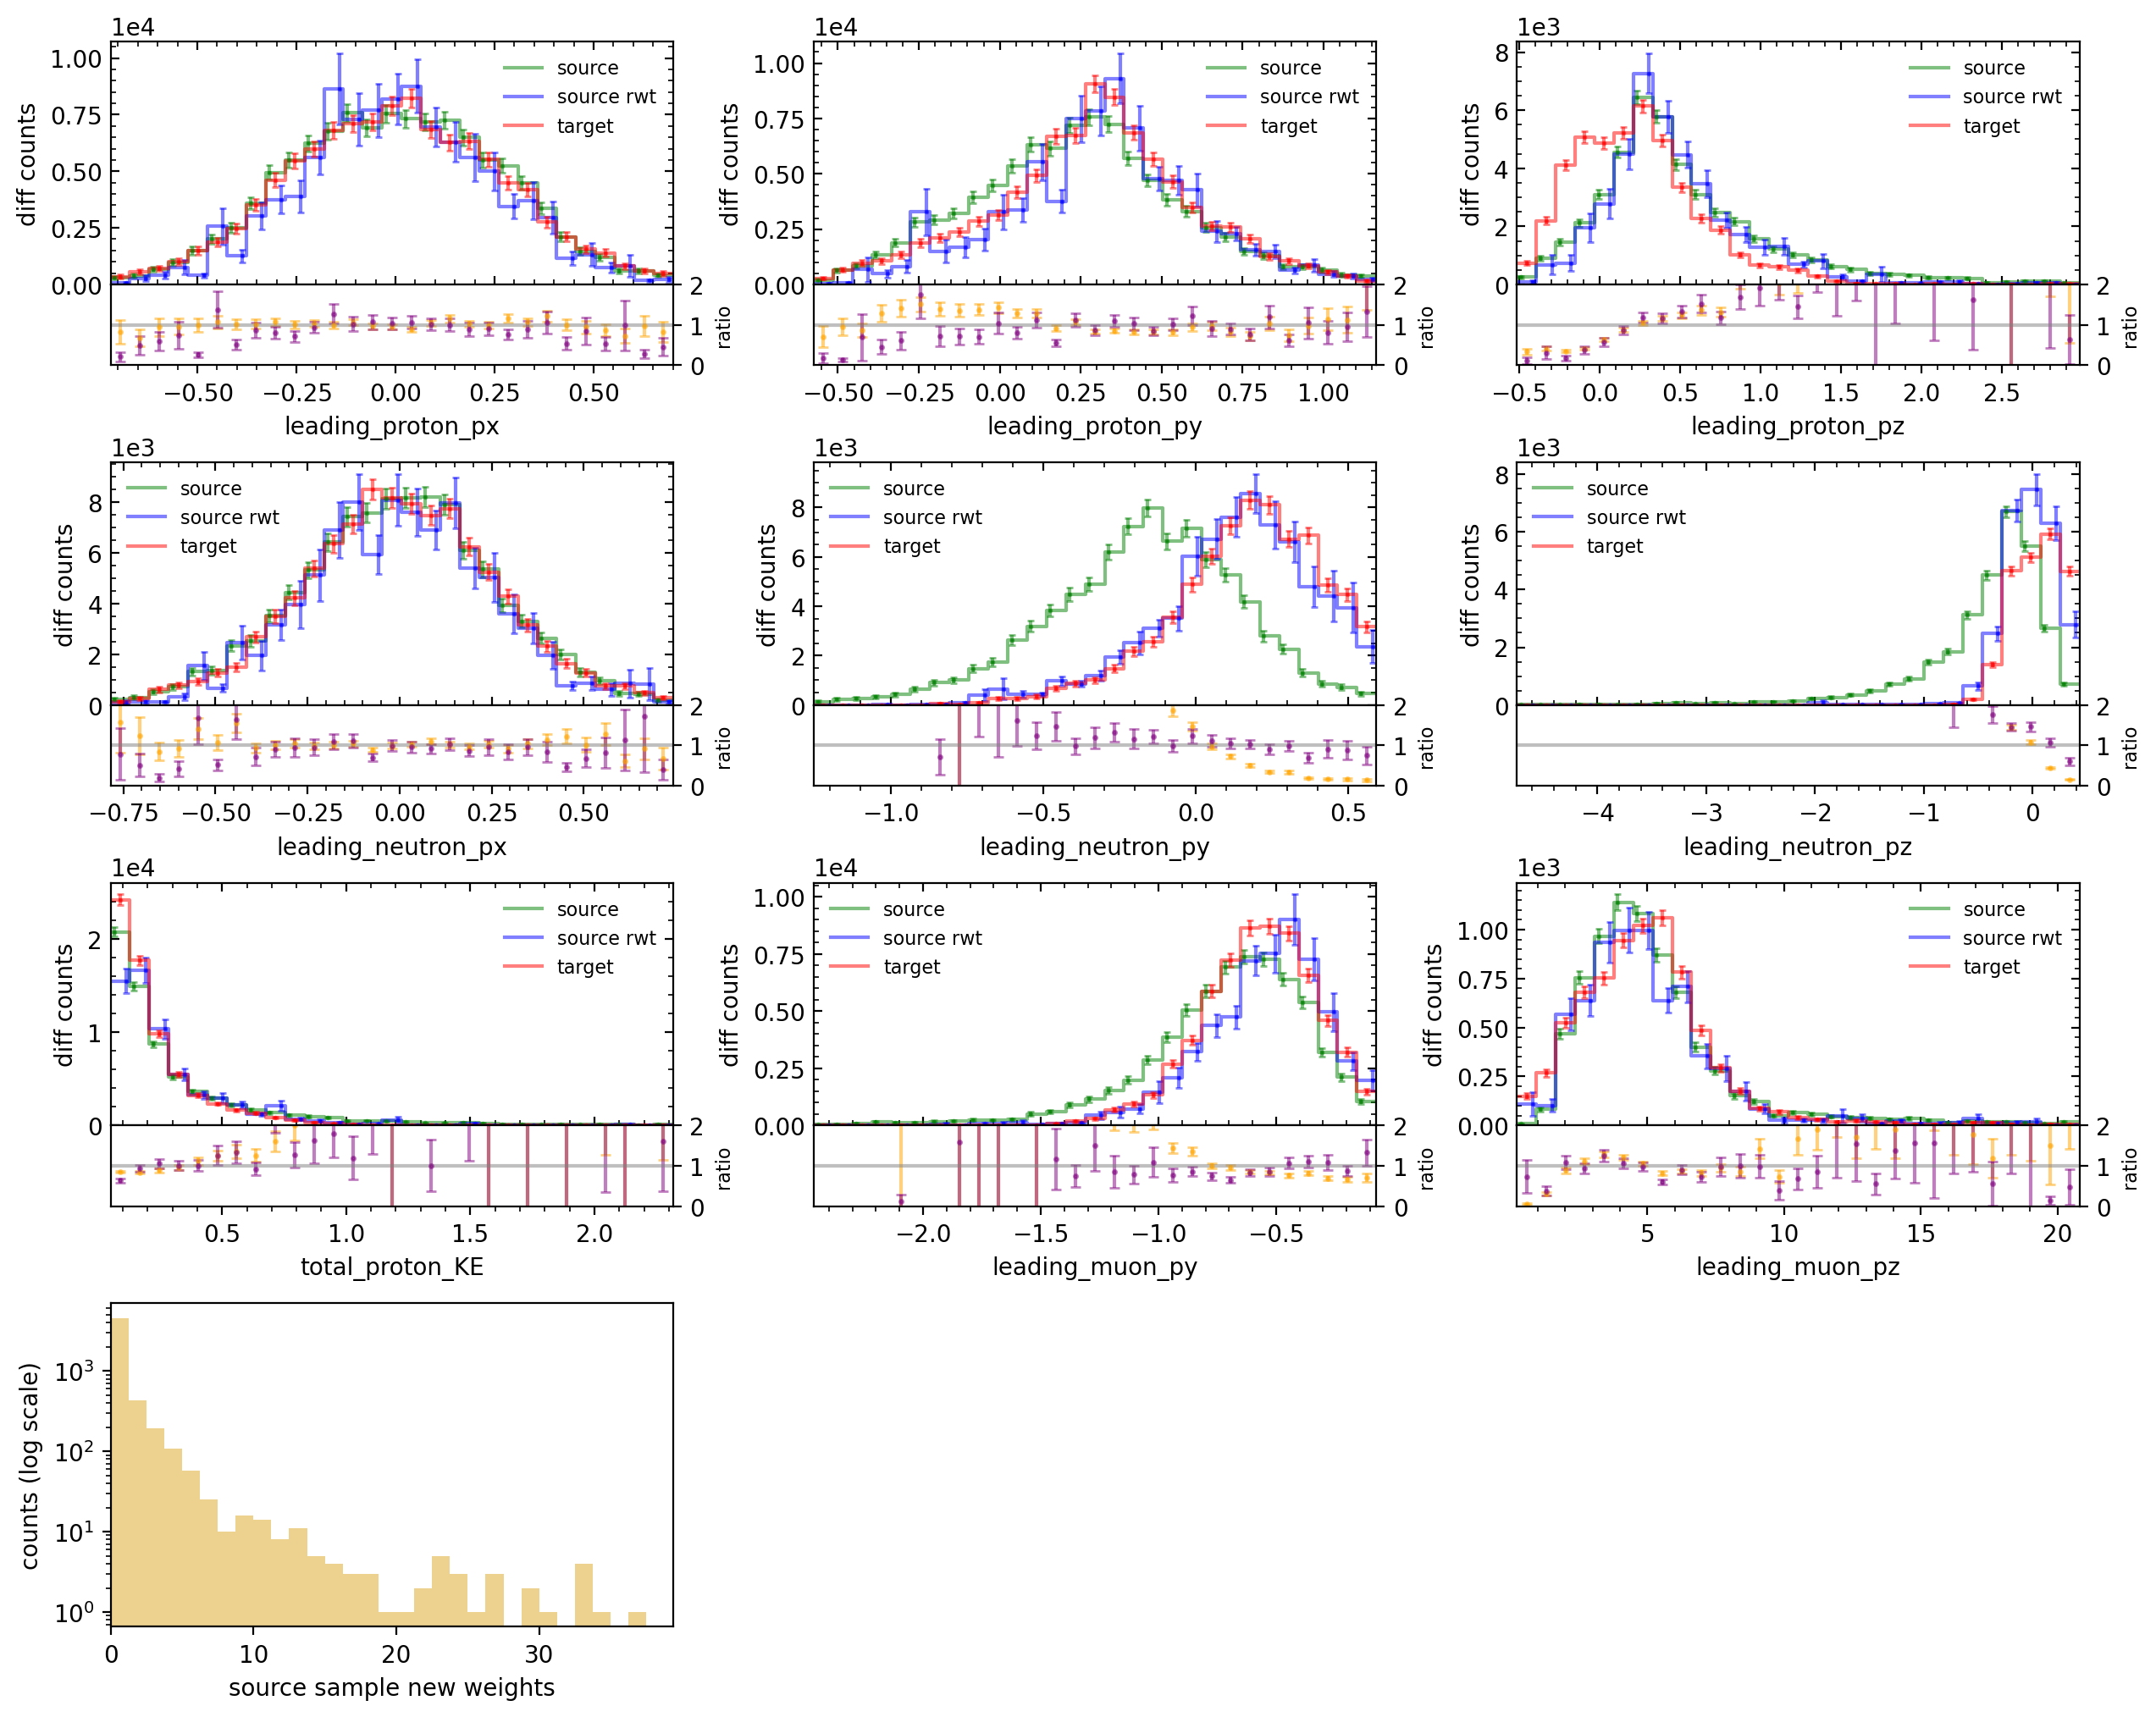

In [7]:
category = '1pNn'
particle_counts = {'muon':'==1', 'proton':'==1', 'neutron':'>=1'}
variable_exprs = [
    'Enu_true', 'Q2', 'q0', 'q3', 'W',
    'dalphat', 'dpt', 'dphit',
    'leading_muon_px', 'leading_muon_py', 'leading_muon_pz', 'leading_muon_KE',
    'total_proton_px', 'total_proton_py', 'total_proton_pz', 'total_proton_KE',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz', 'leading_proton_KE',
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz', 'leading_neutron_KE',
]
reweight_variables=['leading_proton_px','leading_proton_py','leading_proton_pz','total_proton_KE',
    'leading_muon_py','leading_muon_pz', 'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',]
particle_names = ['leading_proton','leading_neutron','total_proton']
drawing_variables = [
    'leading_proton_px','leading_proton_py','leading_proton_pz',
    'leading_neutron_px','leading_neutron_py','leading_neutron_pz',
    'total_proton_KE','leading_muon_py','leading_muon_pz',
    # 'total_proton_px','total_proton_py','total_proton_pz',
    # 'dalphat', 'dpt', 'dphit', 
    'weight'
]

mask = tree_target_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_train[category] = create_dataframe_from_nuisance(tree_target_train, variable_exprs=variable_exprs, mask=mask)
target_train[category] = transform_momentum_to_reaction_frame(target_train[category], selector_lepton='leading_muon', particle_names=particle_names)

target_test[category] = target_train[category].copy()

reweighter = Reweighter(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=30, gb_args={'subsample': 1.0})
reweighter.fit(source_train[category][reweight_variables], target_train[category][reweight_variables])


target_test[category]['weight'] = 1.0
source_test[category]['weight'] = reweighter.predict_matched_total_weights(
    source_test[category][reweight_variables], 
    original_weight=None,
    target_weight=target_test[category]['weight']
)
source_test[category] = source_test[category].loc[source_test[category]['weight']<40]


draw_source_target_distributions_and_ratio(source_test[category], target_test[category], 
    variables = drawing_variables,
    source_weights = np.ones(len(source_test[category])),
    target_weights = np.ones(len(target_test[category])), 
    new_source_weights = source_test[category]['weight'],
    # xlabels = [particle_variable_to_latex(var) for var in drawing_variables],
    # ylabels = [diff_xsec_latex_wrt_variable(var) for var in drawing_variables],
    # scale_source = scale_source_test, scale_target = scale_target_test
)


### CCQE-like 1 $\mu$ 2p0n:

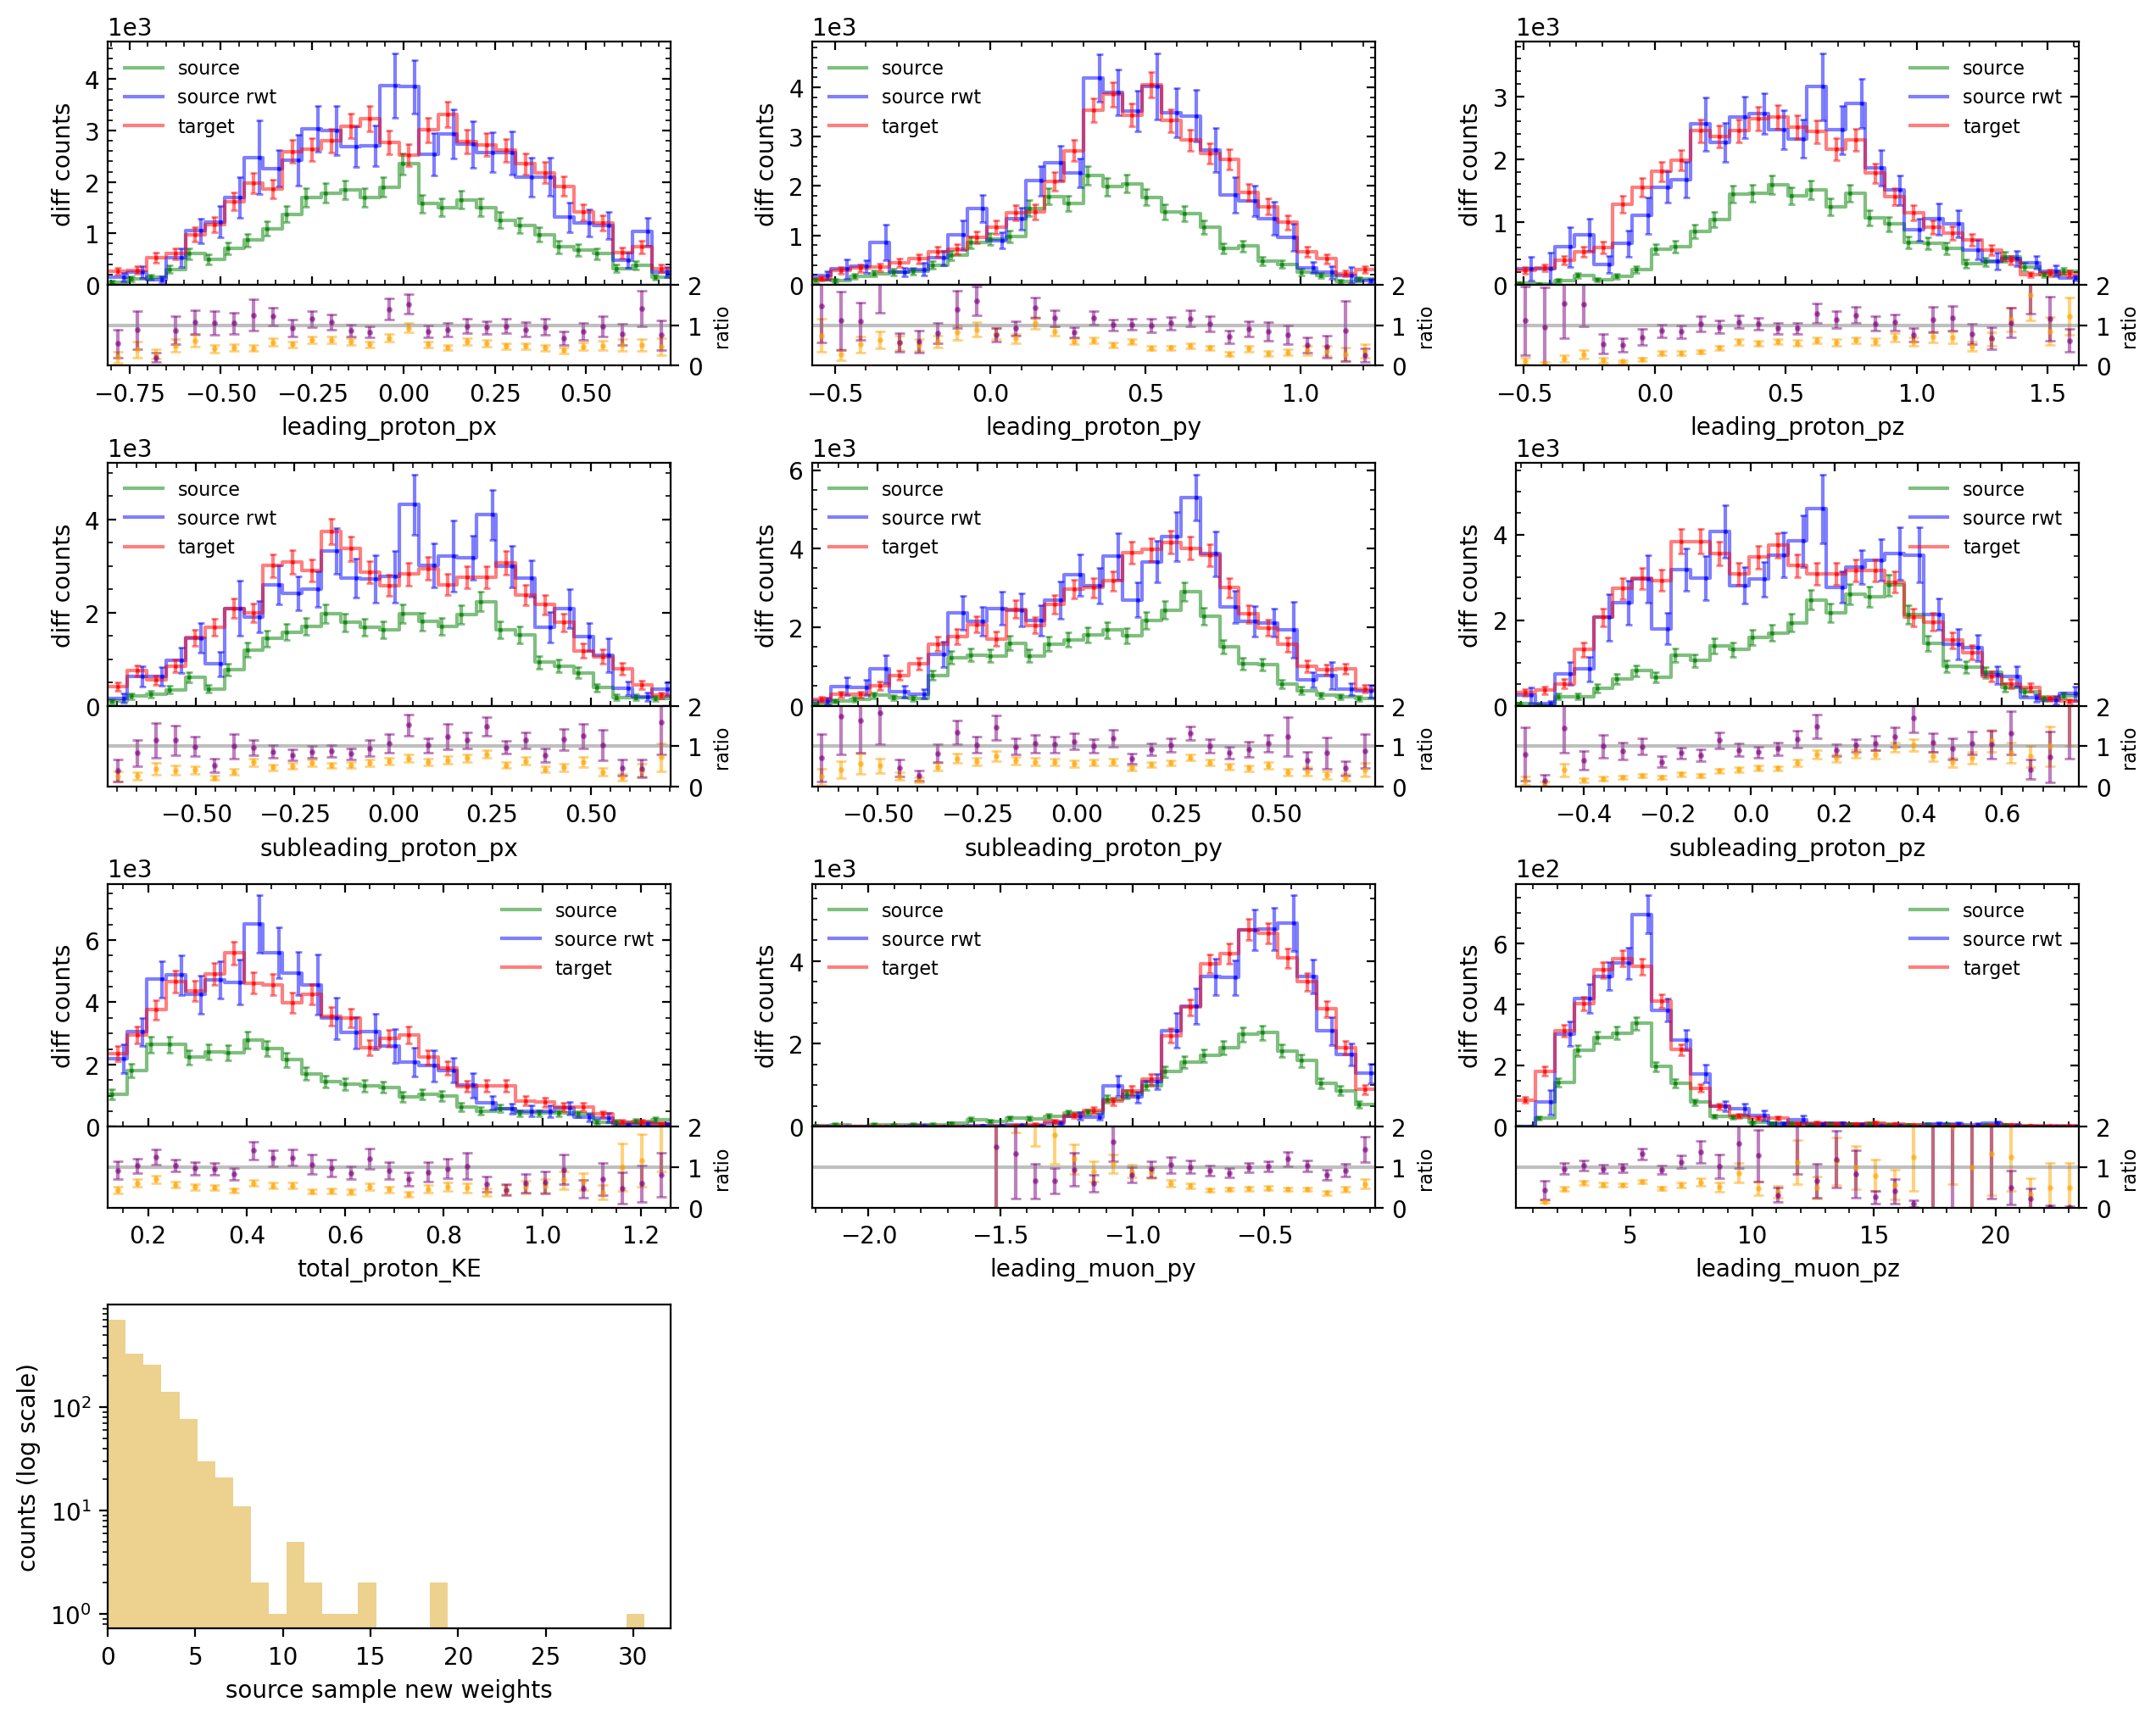

In [8]:
category = '2p0n'
particle_counts = {'muon':'==1', 'proton':'==2', 'neutron':'==0'}
variable_exprs = [
    'Enu_true', 'Q2', 'q0', 'q3', 'W',
    'dalphat', 'dpt', 'dphit',
    'leading_muon_px', 'leading_muon_py', 'leading_muon_pz', 'leading_muon_KE',
    'total_proton_px', 'total_proton_py', 'total_proton_pz', 'total_proton_KE',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz', 'leading_proton_KE',
    'subleading_proton_px', 'subleading_proton_py', 'subleading_proton_pz', 'subleading_proton_KE'
]
reweight_variables=['leading_proton_px','leading_proton_py','leading_proton_pz','total_proton_KE',
    'leading_muon_py','leading_muon_pz', 'subleading_proton_px', 'subleading_proton_py', 'subleading_proton_pz',]
particle_names = ['leading_proton','subleading_proton','total_proton']
drawing_variables = [
    'leading_proton_px','leading_proton_py','leading_proton_pz',
    'subleading_proton_px','subleading_proton_py','subleading_proton_pz',
    'total_proton_KE','leading_muon_py','leading_muon_pz', 
    # 'total_proton_px','total_proton_py','total_proton_pz', 
    # 'dalphat', 'dpt', 'dphit', 
    'weight'
]
mask = tree_target_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_train[category] = create_dataframe_from_nuisance(tree_target_train, variable_exprs=variable_exprs, mask=mask)
target_train[category] = transform_momentum_to_reaction_frame(target_train[category], selector_lepton='leading_muon', particle_names=particle_names)

target_test[category] = target_train[category].copy()

reweighter = Reweighter(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=30, gb_args={'subsample': 1.0})
reweighter.fit(source_train[category][reweight_variables], target_train[category][reweight_variables])


target_test[category]['weight'] = 1.0
source_test[category]['weight'] = reweighter.predict_matched_total_weights(
    source_test[category][reweight_variables], 
    original_weight=None,
    target_weight=target_test[category]['weight']
)
source_test[category] = source_test[category].loc[source_test[category]['weight']<40]

draw_source_target_distributions_and_ratio(source_test[category], target_test[category], 
    variables = drawing_variables,
    source_weights = np.ones(len(source_test[category])),
    target_weights = np.ones(len(target_test[category])), 
    new_source_weights = source_test[category]['weight'],
    # xlabels = [particle_variable_to_latex(var) for var in drawing_variables],
    # ylabels = [diff_xsec_latex_wrt_variable(var) for var in drawing_variables],
    # scale_source = scale_source_test, scale_target = scale_target_test
)


### CCQE-like 1 $\mu$ 2pNn:

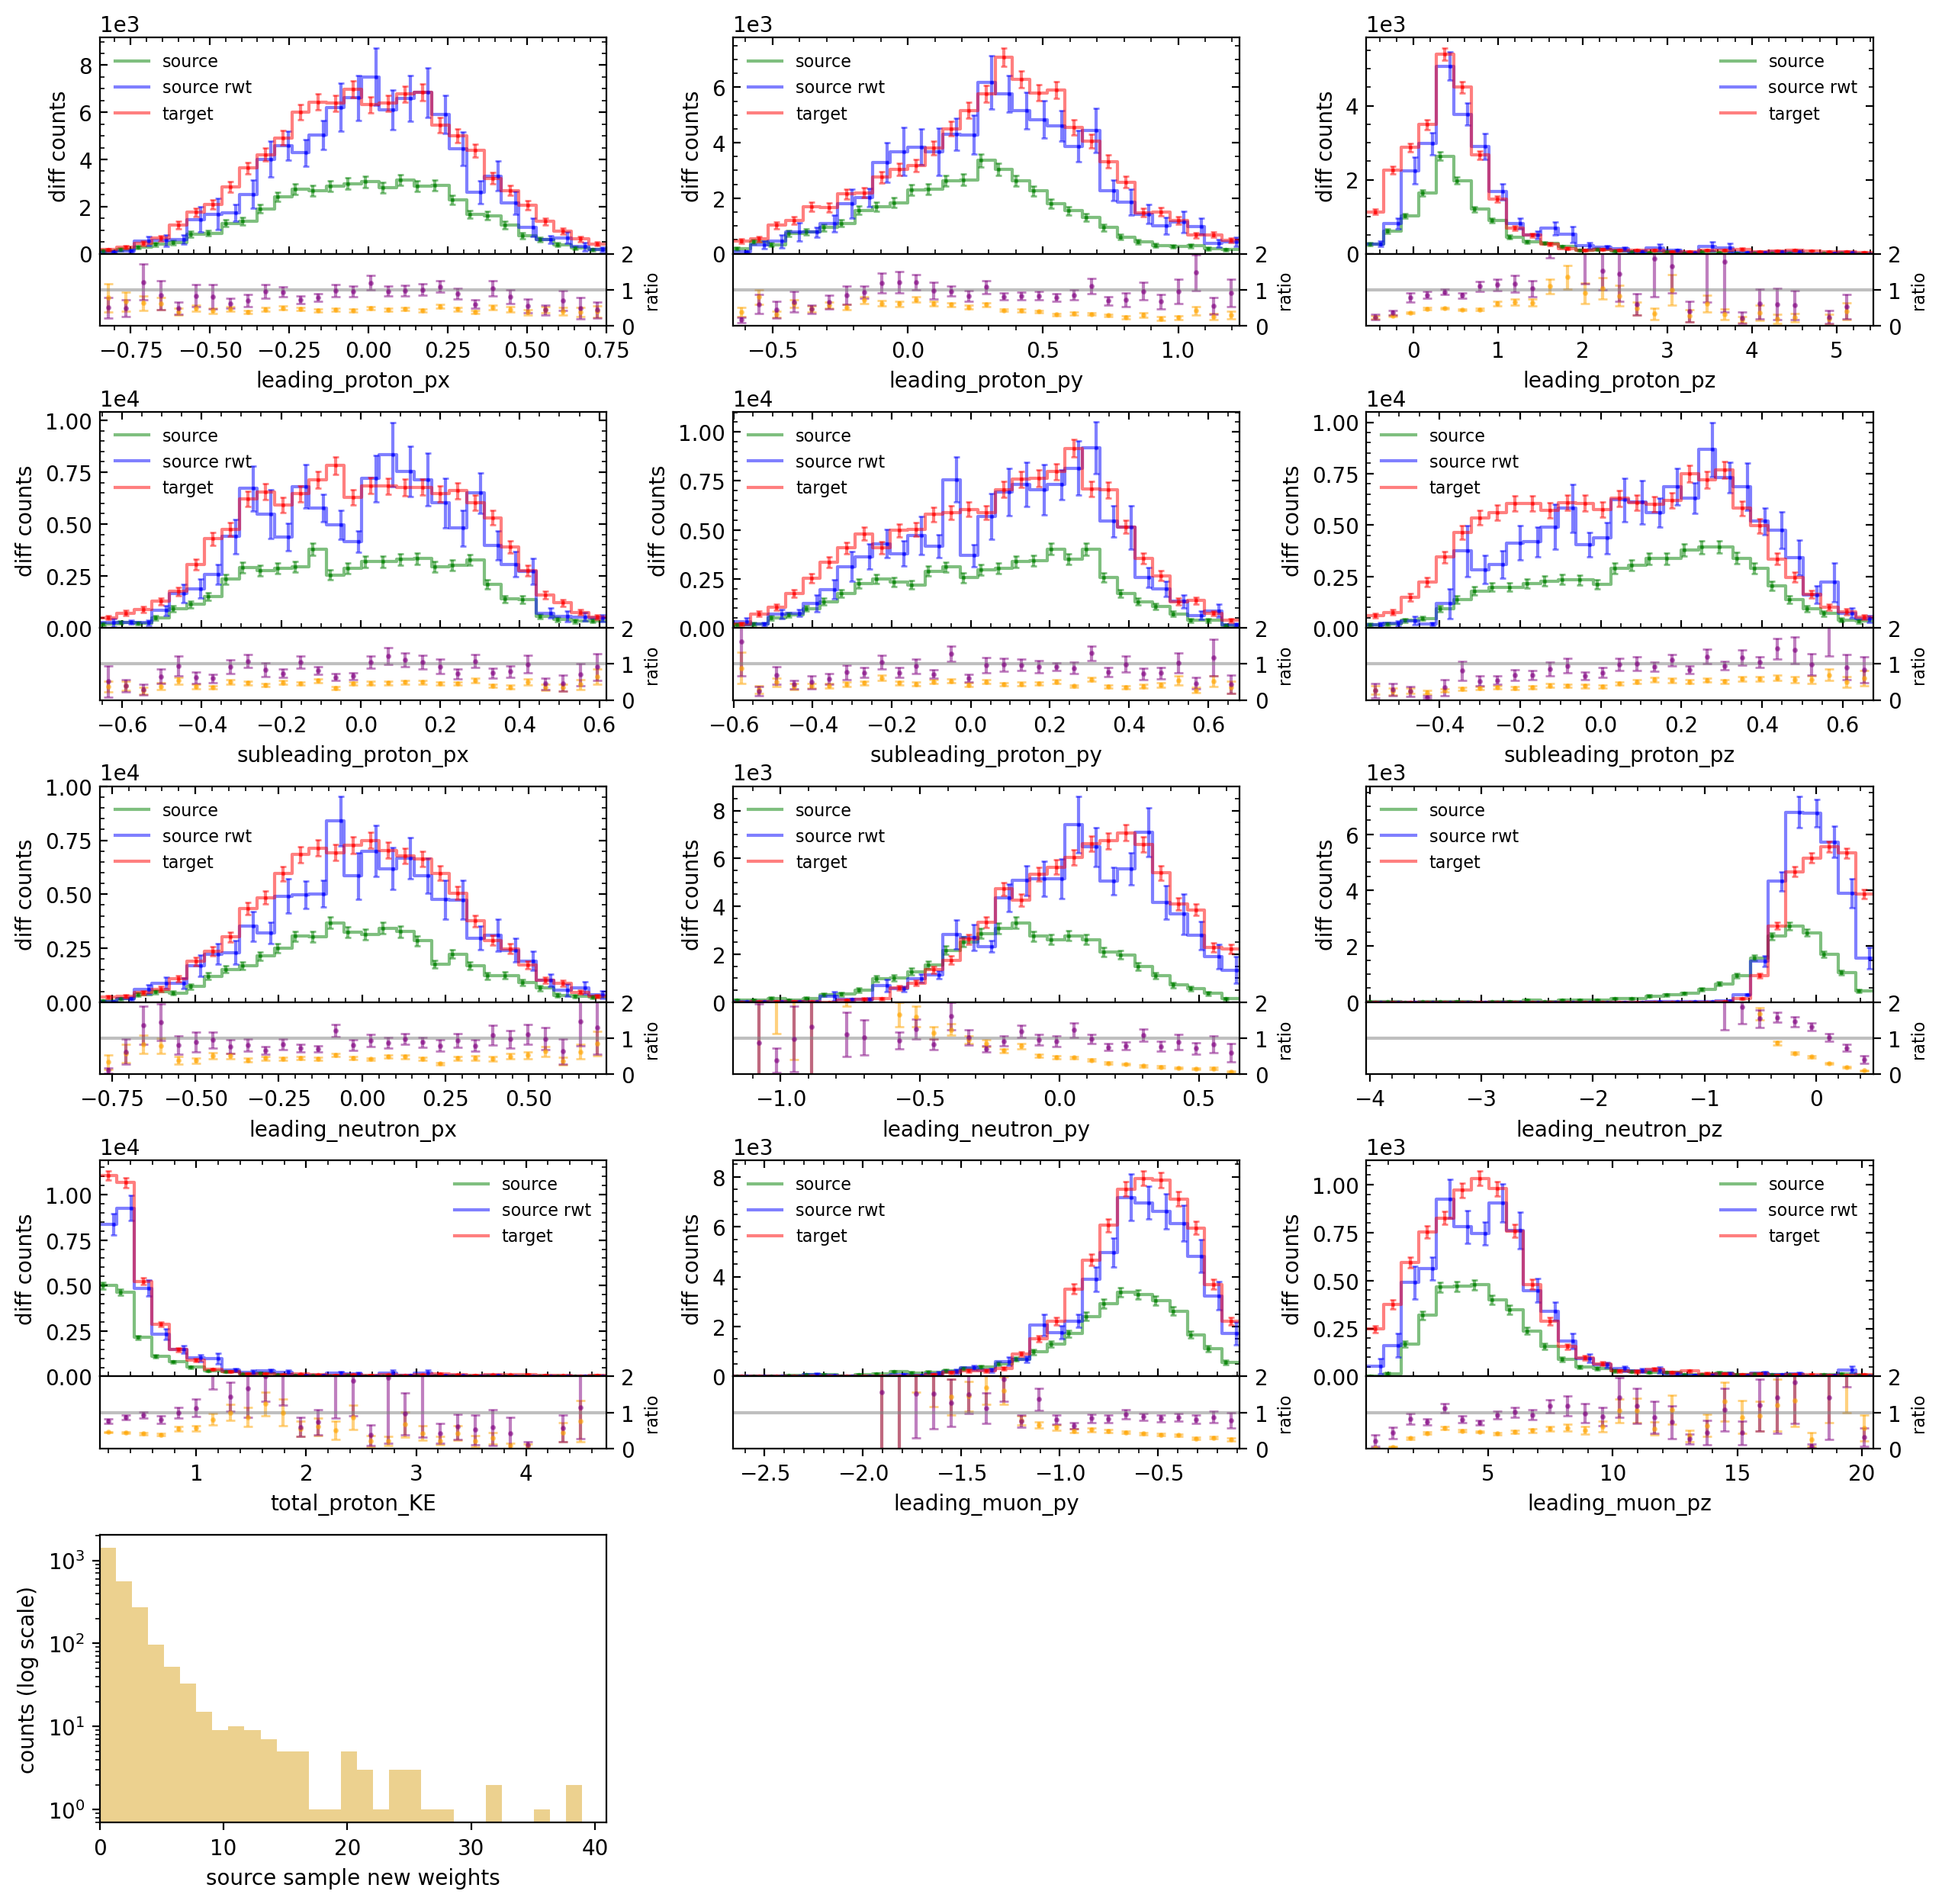

In [9]:
category = '2pNn'
particle_counts = {'muon':'==1', 'proton':'==2', 'neutron':'>=1'}
variable_exprs = [
    'Enu_true', 'Q2', 'q0', 'q3', 'W',
    'dalphat', 'dpt', 'dphit',
    'leading_muon_px', 'leading_muon_py', 'leading_muon_pz', 'leading_muon_KE',
    'total_proton_px', 'total_proton_py', 'total_proton_pz', 'total_proton_KE',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz', 'leading_proton_KE',
    'subleading_proton_px', 'subleading_proton_py', 'subleading_proton_pz', 'subleading_proton_KE',
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz', 'leading_neutron_KE'
]
reweight_variables=['leading_proton_px','leading_proton_py','leading_proton_pz','total_proton_KE',
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'leading_muon_py','leading_muon_pz', 'subleading_proton_px', 'subleading_proton_py', 'subleading_proton_pz',]
particle_names = ['leading_proton','subleading_proton','leading_neutron','total_proton']
drawing_variables = [
    'leading_proton_px','leading_proton_py','leading_proton_pz',
    'subleading_proton_px','subleading_proton_py','subleading_proton_pz',
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'total_proton_KE','leading_muon_py','leading_muon_pz',
    # 'total_proton_px','total_proton_py','total_proton_pz',
    # 'dalphat', 'dpt', 'dphit', 
    'weight'
]

mask = tree_target_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_train[category] = create_dataframe_from_nuisance(tree_target_train, variable_exprs=variable_exprs, mask=mask)
target_train[category] = transform_momentum_to_reaction_frame(target_train[category], selector_lepton='leading_muon', particle_names=particle_names)

target_test[category] = target_train[category].copy()

reweighter = Reweighter(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=30, gb_args={'subsample': 1.0})
reweighter.fit(source_train[category][reweight_variables], target_train[category][reweight_variables])


target_test[category]['weight'] = 1.0
source_test[category]['weight'] = reweighter.predict_matched_total_weights(
    source_test[category][reweight_variables], 
    original_weight=None,
    target_weight=target_test[category]['weight']
)
source_test[category] = source_test[category].loc[source_test[category]['weight']<40]


draw_source_target_distributions_and_ratio(source_test[category], target_test[category], 
    variables = drawing_variables,
    source_weights = np.ones(len(source_test[category])),
    target_weights = np.ones(len(target_test[category])), 
    new_source_weights = source_test[category]['weight'],
    # xlabels = [particle_variable_to_latex(var) for var in drawing_variables],
    # ylabels = [diff_xsec_latex_wrt_variable(var) for var in drawing_variables],
    # scale_source = scale_source_test, scale_target = scale_target_test
)


### CCQE-like others:

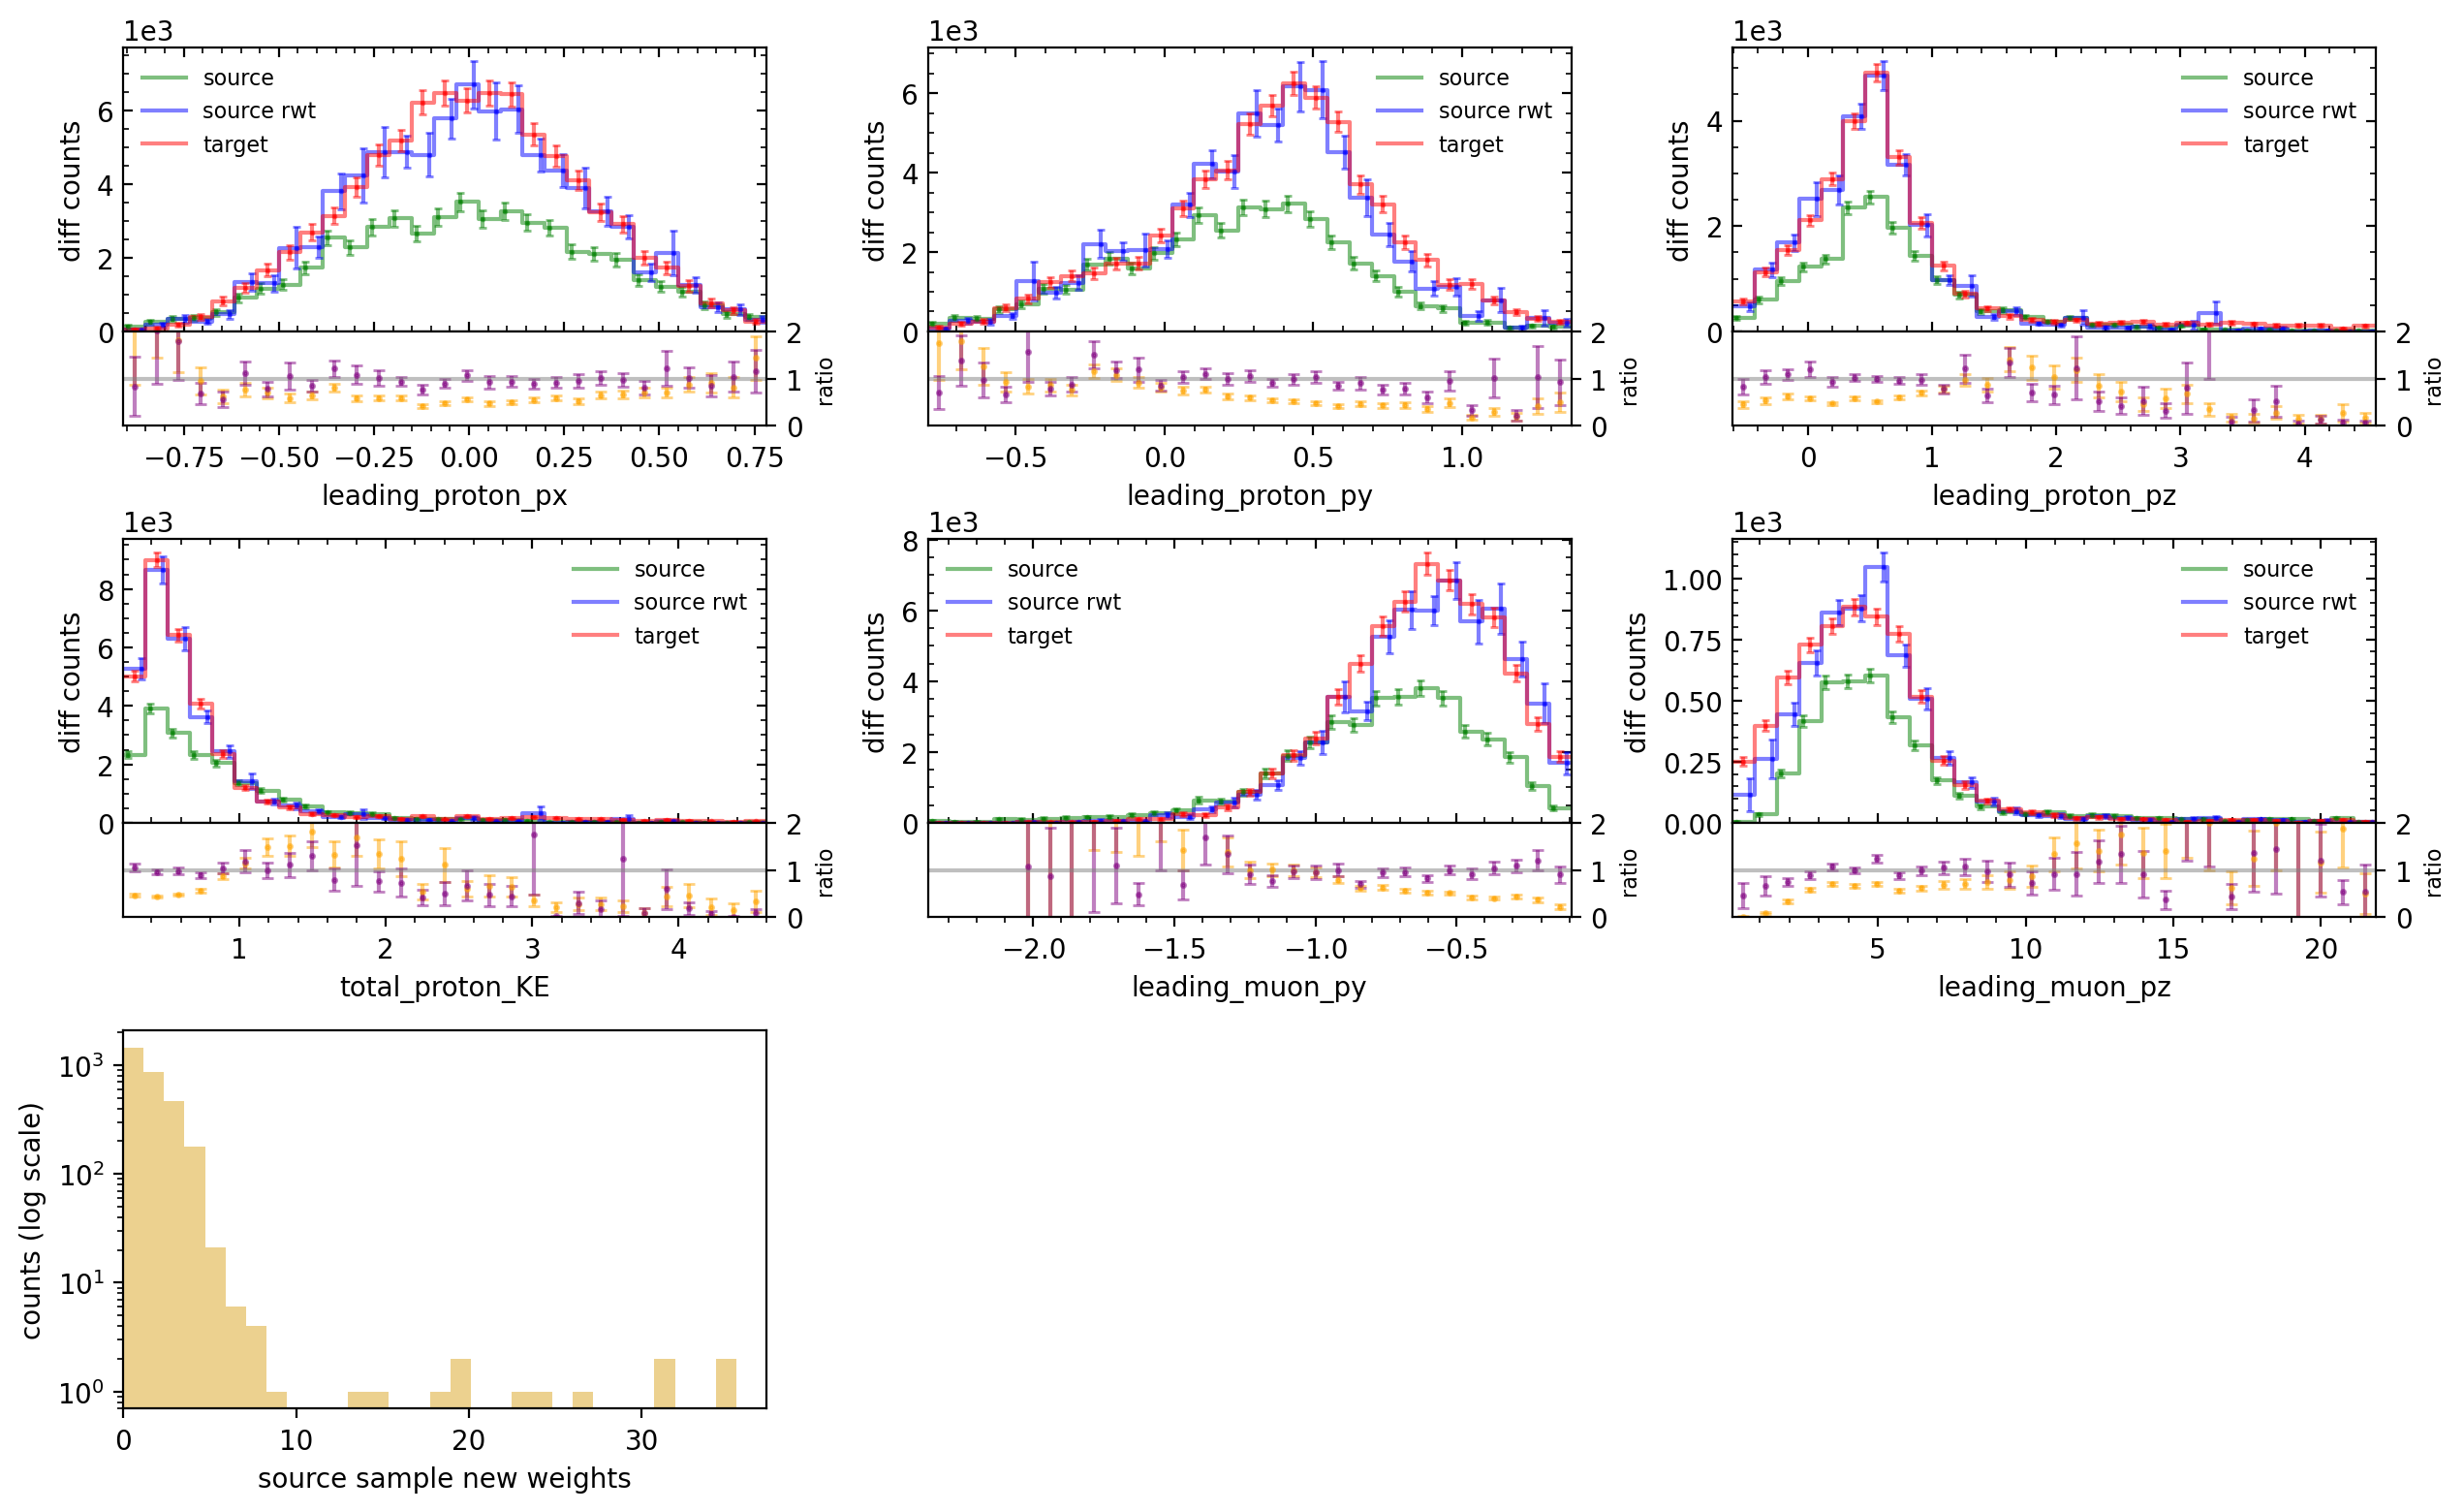

In [10]:
category = 'others'
particle_counts = {'muon':'==1', 'proton':'>=3'}
variable_exprs = [
    'Enu_true', 'Q2', 'q0', 'q3', 'W',
    'dalphat', 'dpt', 'dphit',
    'leading_muon_px', 'leading_muon_py', 'leading_muon_pz', 'leading_muon_KE',
    'total_proton_px', 'total_proton_py', 'total_proton_pz', 'total_proton_KE',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz', 'leading_proton_KE',
]
reweight_variables=['leading_proton_px','leading_proton_py','leading_proton_pz','total_proton_KE',
    'leading_muon_py','leading_muon_pz']
particle_names = ['leading_proton','total_proton']
drawing_variables = [
    'leading_proton_px','leading_proton_py','leading_proton_pz',
    'total_proton_KE','leading_muon_py','leading_muon_pz', 
    # 'total_proton_px','total_proton_py','total_proton_pz', 
    # 'dalphat', 'dpt', 'dphit', 
    'weight'
]

mask = tree_target_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_train[category] = create_dataframe_from_nuisance(tree_target_train, variable_exprs=variable_exprs, mask=mask)
target_train[category] = transform_momentum_to_reaction_frame(target_train[category], selector_lepton='leading_muon', particle_names=particle_names)

target_test[category] = target_train[category].copy()

reweighter = Reweighter(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=30, gb_args={'subsample': 1.0})
reweighter.fit(source_train[category][reweight_variables], target_train[category][reweight_variables])


target_test[category]['weight'] = 1.0
source_test[category]['weight'] = reweighter.predict_matched_total_weights(
    source_test[category][reweight_variables], 
    original_weight=None,
    target_weight=target_test[category]['weight']
)
source_test[category] = source_test[category].loc[source_test[category]['weight']<40]

draw_source_target_distributions_and_ratio(source_test[category], target_test[category], 
    variables = drawing_variables,
    source_weights = np.ones(len(source_test[category])),
    target_weights = np.ones(len(target_test[category])), 
    new_source_weights = source_test[category]['weight'],
    # xlabels = [particle_variable_to_latex(var) for var in drawing_variables],
    # ylabels = [diff_xsec_latex_wrt_variable(var) for var in drawing_variables],
    # scale_source = scale_source_test, scale_target = scale_target_test
)
